## Load Dependencies

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import RandomizedSearchCV, cross_val_score
import matplotlib.pyplot as plt
import sklearn.gaussian_process as gp
from sklearn.datasets import load_wine, make_classification
from sklearn.svm import SVC
from skopt import gp_minimize, forest_minimize, dummy_minimize, expected_minimum
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt.plots import plot_convergence
from sklearn.gaussian_process import GaussianProcessRegressor
from skopt.plots import plot_evaluations
from skopt.plots import plot_objective

/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# Create new Dataset

In [2]:
#%run python/gp.py
#%run python/plotters.py

In [3]:
data, target = make_classification(n_samples=2500,
                                   n_features=45,
                                   n_informative=15,
                                   n_redundant=5)

# Helper Functions

In [4]:
def sample_loss(params):
    return cross_val_score(SVC(C=10 ** params[0], gamma=10 ** params[1], random_state=12345),
                           X=data, y=target, scoring='roc_auc', cv=3).mean()

In [83]:
def plot_intermediate(res,opt):
    iteration = len(res.func_vals)
    if(iteration >= 10):
        plot_evaluations(res)
        plt.savefig("images/%s/eval_iteration_%d.png"%(opt,iteration))
        plt.close()
        plot_objective(res)
        plt.savefig("images/%s/obj_iteration_%d.png"%(opt,iteration))
        plt.close()


# Calculate objective function

In [44]:
lambdas = np.linspace(-5,2,30)
gammas = np.linspace(-5,2,30)
# We need the cartesian combination of these two vectors
param_grid = np.array([[C, gamma] for gamma in gammas for C in lambdas])

In [45]:
real_loss = [sample_loss(params) for params in param_grid]

# The maximum is at:
param_grid[np.array(real_loss).argmax(), :]

array([ 0.31034483, -2.10344828])

In [46]:
# Best score
max_score = sample_loss(param_grid[np.array(real_loss).argmax(), :])
max_score

0.9889811126564529

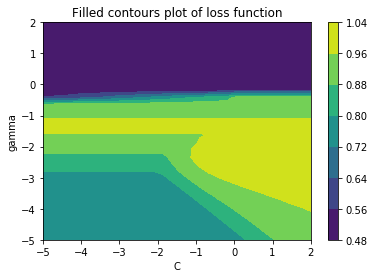

In [48]:
#from matplotlib import rc
#rc('text', usetex=True)

C, G = np.meshgrid(lambdas, gammas)
plt.figure()
cp = plt.contourf(C, G, np.array(real_loss).reshape(C.shape))
plt.colorbar(cp)
plt.title('Filled contours plot of loss function')
plt.xlabel('C')
plt.ylabel('gamma')
#plt.savefig('/Users/thomashuijskens/Personal/gp-optimisation/figures/real_loss_contour.png', bbox_inches='tight')
plt.show()

# Set up surrogate models

In [84]:
# Hyperparameter

#dimensions = [Real(0+1e-10,10-1e-10,"uniform",name="C"),Real(0+1e-10,10-1e-10,"uniform",name="gamma"),Categorical(["rbf","poly","linear","sigmoid"],name="kernel")]
dimensions = [Real(1e-5,100,"log-uniform",name="C"),Real(1e-5,100,"log-uniform",name="gamma")]

# Objective Function (test-score)
@use_named_args(dimensions)
def f(**params):
    clf = SVC(**params)
    return -cross_val_score(clf,X=data, y=target, scoring='roc_auc', cv=3).mean()

### Run optimization with different surrogate models:
# (1) Gaussian Process
# (2) Random Forest
# (3) No model (random search)

GP Model

In [85]:
gp_res = gp_minimize(f, dimensions=dimensions, acq_func="EI", n_calls=100, n_jobs=-1, callback = lambda res: plot_intermediate(res,"gp"))  

Random Forest Model

In [86]:
rf_res = forest_minimize(f, dimensions=dimensions, acq_func="EI", n_calls=100, n_jobs=-1, callback = lambda res: plot_intermediate(res,"rf"))  

No Model (random search)

In [87]:
dummy_res = dummy_minimize(f, dimensions=dimensions, n_calls=100)

In [88]:
# Zip results
gp_results = list(zip(gp_res.x_iters,list(-gp_res.func_vals)))
rf_results = list(zip(rf_res.x_iters,list(-rf_res.func_vals)))
dummy_results = list(zip(dummy_res.x_iters,list(-dummy_res.func_vals)))

# Convergence

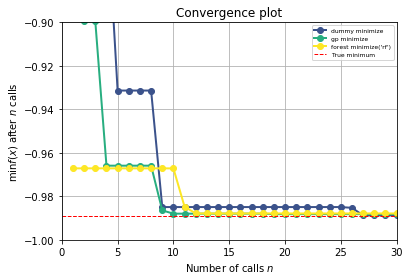

In [89]:
plot = plot_convergence(("dummy minimize", dummy_res),
                        ("gp minimize", gp_res),
                        ("forest minimize('rf')", rf_res),
                        true_minimum=-max_score)

plot.legend(loc="best", prop={'size': 6}, numpoints=1)
plt.xlim(0,30)
plt.ylim(-1,-0.9)
plt.show()

# Sampling
Random Search

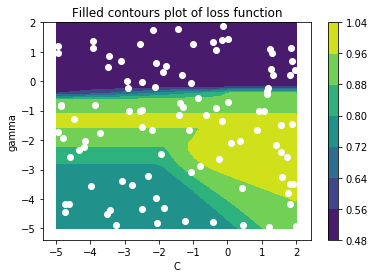

In [90]:
#from matplotlib import rc
#rc('text', usetex=True)

C, G = np.meshgrid(lambdas, gammas)
plt.figure()
cp = plt.contourf(C, G, np.array(real_loss).reshape(C.shape))
plt.colorbar(cp)
plt.title('Filled contours plot of loss function')
plt.xlabel('C')
plt.ylabel('gamma')
#plt.savefig('/Users/thomashuijskens/Personal/gp-optimisation/figures/real_loss_contour.png', bbox_inches='tight')
plt.scatter(x=[np.log10(a[0][0]) for a in dummy_results],y=[np.log10(a[0][1]) for a in dummy_results],color="white")
plt.show()

Random Forest

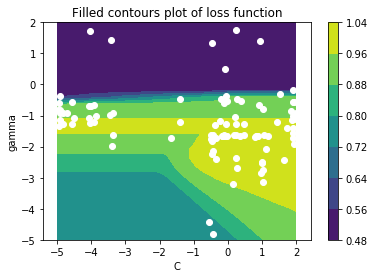

In [91]:
#from matplotlib import rc
#rc('text', usetex=True)

C, G = np.meshgrid(lambdas, gammas)
plt.figure()
cp = plt.contourf(C, G, np.array(real_loss).reshape(C.shape))
plt.colorbar(cp)
plt.title('Filled contours plot of loss function')
plt.xlabel('C')
plt.ylabel('gamma')
#plt.savefig('/Users/thomashuijskens/Personal/gp-optimisation/figures/real_loss_contour.png', bbox_inches='tight')
plt.scatter(x=[np.log10(a[0][0]) for a in rf_results],y=[np.log10(a[0][1]) for a in rf_results],color="white")
plt.show()

Gaussian Process

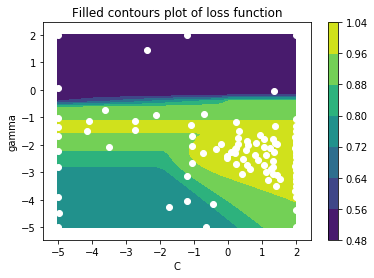

In [92]:
#from matplotlib import rc
#rc('text', usetex=True)

C, G = np.meshgrid(lambdas, gammas)
plt.figure()
cp = plt.contourf(C, G, np.array(real_loss).reshape(C.shape))
plt.colorbar(cp)
plt.title('Filled contours plot of loss function')
plt.xlabel('C')
plt.ylabel('gamma')
#plt.savefig('/Users/thomashuijskens/Personal/gp-optimisation/figures/real_loss_contour.png', bbox_inches='tight')
plt.scatter(x=[np.log10(a[0][0]) for a in gp_results],y=[np.log10(a[0][1]) for a in gp_results],color="white")
plt.show()

In [95]:
# Create a gif from the images
import imageio

images = []

for i in range(10,100):
    filename = "C:/users/kocha/git/untitled folder/images/gp/obj_iteration_%d.png" % i
    images.append(imageio.imread(filename))
imageio.mimsave('C:/users/kocha/git/untitled folder/images/objective.gif', images, duration=0.1)

images = []

for i in range(10,100):
    filename = "C:/users/kocha/git/untitled folder/images/gp/eval_iteration_%d.png" % i
    images.append(imageio.imread(filename))
imageio.mimsave('C:/users/kocha/git/untitled folder/images/eval.gif', images, duration=0.1)

# GP objective

![SegmentLocal](img/eval_gp.gif 'segment')

# RF objective


![SegmentLocal](img/eval_rf.gif "segment")

## Objective RF
![SegmentLocal](img/objective_rf.gif 'segment')

## Objective GP
![SegmentLocal](img/objective_gp.gif 'segment')